In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
# Deep Learning
import tensorflow as tf

In [3]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [4]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [106]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [107]:
add_data_info()

In [108]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [109]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [110]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

In [132]:
df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,serve_return
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,f18
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,1,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,f2
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,0,0,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,0,1,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,b3
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,1,0,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,r28


In [115]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

## Dataset finalizado ##

In [117]:
df['serve_return'].nunique()

588

In [118]:
df['rally_desc'].nunique()

9812

In [85]:
#df = df[df['serve_return']!=""]

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18751 entries, 0 to 19323
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              18751 non-null  int64  
 1   match_id           18751 non-null  object 
 2   Pt                 18751 non-null  int64  
 3   Set1               18751 non-null  int64  
 4   Set2               18751 non-null  int64  
 5   Gm1                18751 non-null  int64  
 6   Gm2                18751 non-null  int64  
 7   Pts                18751 non-null  object 
 8   Gm#                18751 non-null  object 
 9   TbSet              18751 non-null  object 
 10  TB?                18751 non-null  object 
 11  TBpt               656 non-null    float64
 12  Svr                18751 non-null  int64  
 13  Ret                18751 non-null  int64  
 14  Serving            18751 non-null  object 
 15  1st                18751 non-null  object 
 16  2nd                663

## Geração das features

In [122]:
features = ['Surface',
            'Round',
            'Grand Slam',
            'i_serve',
            'is_second_service',
            'dir_srv',
            'rallyCount',
            'isUnforced',
            'isForced',
            "serve_return"
            ]
X = df[features]
y = df['i_win']

In [123]:
feat_categorical = ['Surface','Round','dir_srv','serve_return']

In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18751 entries, 0 to 19323
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Surface            18751 non-null  object
 1   Round              18751 non-null  object
 2   Grand Slam         18751 non-null  int64 
 3   i_serve            18751 non-null  int64 
 4   is_second_service  18751 non-null  int64 
 5   dir_srv            18751 non-null  int64 
 6   rallyCount         18751 non-null  int64 
 7   isUnforced         18751 non-null  int64 
 8   isForced           18751 non-null  int64 
 9   serve_return       18751 non-null  object
dtypes: int64(7), object(3)
memory usage: 1.6+ MB


## separação - treino, teste e validação

In [126]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
train, test = train_test_split(df, test_size=0.3)

# Train-Val Split
train, val = train_test_split(train, test_size=0.3)


In [127]:
## Separating features and target in the Train, Val and Test Set

X_train = train[features]
y_train = train['i_win']

X_val = val[features]
y_val = val['i_win']

X_test = test[features]
y_test = test['i_win']

In [128]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9187 train examples
3938 validation examples
5626 test examples


In [131]:
X_train['serve_return'].nunique()

384

## Inicio do modelo - pre processamento e encoder

In [95]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [96]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x299d7fe20>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x299d7f8e0>)])

In [97]:
preproc.fit_transform(X_train).shape

(8040, 393)

In [98]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

## Definição do modelo

In [99]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [100]:
model = Sequential()

# 1. Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [101]:
# 3. Training
es = EarlyStopping(monitor = 'val_accuracy',
                   patience = 5,
                   verbose = 0,
                   restore_best_weights = True)

history = model.fit(X_train_preproc,
                   y_train,
                   validation_data = (X_val_preproc, y_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)

Epoch 1/500
126/126 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.5733 - val_loss: 0.6332 - val_accuracy: 0.6475
Epoch 2/500
126/126 [==============================] - 0s 924us/step - loss: 0.6244 - accuracy: 0.6407 - val_loss: 0.6020 - val_accuracy: 0.6667
Epoch 3/500
126/126 [==============================] - 0s 808us/step - loss: 0.6033 - accuracy: 0.6561 - val_loss: 0.5854 - val_accuracy: 0.6699
Epoch 4/500
126/126 [==============================] - 0s 794us/step - loss: 0.5841 - accuracy: 0.6627 - val_loss: 0.5695 - val_accuracy: 0.6745
Epoch 5/500
126/126 [==============================] - 0s 811us/step - loss: 0.5655 - accuracy: 0.6718 - val_loss: 0.5584 - val_accuracy: 0.6751
Epoch 6/500
126/126 [==============================] - 0s 810us/step - loss: 0.5558 - accuracy: 0.6812 - val_loss: 0.5486 - val_accuracy: 0.6760
Epoch 7/500
126/126 [==============================] - 0s 912us/step - loss: 0.5439 - accuracy: 0.6833 - val_loss: 0.5430 - val_accu

## Resultado final / evaluate

In [102]:
res = model.evaluate(X_test_preproc, y_test)
print(f"accuracy = {res[1]:.3f}")

154/154 [==============================] - 0s 433us/step - loss: 0.5336 - accuracy: 0.6975
accuracy = 0.698


In [103]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                12608     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 15)                495       
                                                                 
 dropout_5 (Dropout)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 16        
                                                                 
Total params: 13,119
Trainable params: 13,119
Non-trainable params: 0
_________________________________________________________________


## Verificação loss/accuracy - overfit / underfit

In [104]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

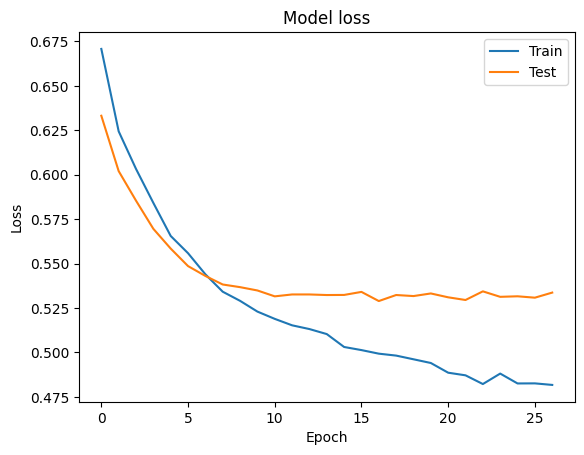

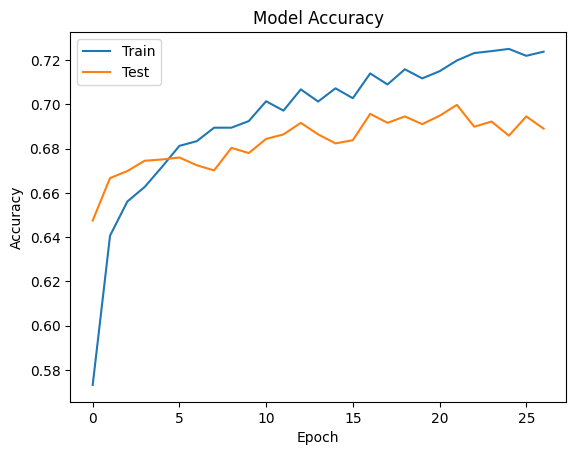

In [105]:
plot_loss_accuracy(history)